# Styling Tool for SAR in Africa  

* **Products used:** 
[s1_rtc]()


## Background


## Description

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Load key Python packages and supporting functions for the analysis.

In [1]:
%matplotlib inline

import os
import datacube
import numpy as np
import pandas as pd
import xarray as xr
import datetime as dt
import glob 
import rasterio
import matplotlib.pyplot as plt
from rasterio.plot import show

import deafrica_tools.temporal as ts
from deafrica_tools.datahandling import load_ard
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.plotting import display_map, rgb
from datacube.utils.aws import configure_s3_access
from deafrica_tools.classification import HiddenPrints
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance
from deafrica_tools.dask import create_local_dask_cluster
configure_s3_access(aws_unsigned=True, cloud_defaults=True)

/env/lib/python3.6/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:40591 Dashboard: /user/neginm/proxy/8787/status,Cluster Workers: 1 Cores: 15 Memory: 104.37 GB


### Analysis parameters
The following cell sets important parameters for the analysis:
* `product`: The satellite product to load. Either Sentinel-2: `'s2_l2a'`, or Sentinel-1: `'s1_rtc'`
* `lat`: The central latitude to analyse (e.g. `-10.6996`).
* `lon`: The central longitude to analyse (e.g. `35.2708`).
* `time_range`: The year range to analyse (e.g. `('2017-01-01', '2019-12-30')`).
* `resolution`: The pixel resolution, in metres, of the returned dataset

In [3]:
product = 's1_rtc'
#set the location 
# Whole Africa 
lat_range = (-34.97,35.89)
lon_range = (-17.55, 50.53)
# Set the range of dates for the analysis
time_range = ('2020-01-01','2020-01-12')
min_gooddata = 0.15
resolution = (-5000,5000)


### Connect to the datacube

Connect to the datacube so we can access DE Africa data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [4]:
dc = datacube.Datacube(app='SARTool')

In [5]:
dc.list_products().loc[dc.list_products()['description'].str.contains('radar')]

,name,description,platform,product_type,format,instrument,creation_time,region_code,label,lat,dataset_maturity,product_family,lon,time,crs,resolution,tile_size,spatial_dimensions
id,,,,,,,,,,,,,,,,,,
3,s1_rtc,Sentinel 1 Gamma0 normalised radar backscatter,None,NaN,None,None,None,NaN,None,None,NaN,NaN,None,None,NaN,NaN,NaN,NaN


## Load Sentinel-1 radar backscatter data and cloud-masked Sentinel-2 

The first step is to load Sentinel-1 radar backscatter data for the specified area of interest and time range. 
`dc.load()` function is used to return a time series of satellite images. The returned xarray.Dataset dataset will contain analysis ready images over agriculture field in part of Tanzania.

In [6]:
# Create a reusable query for Sentinel-1
query_S1 = {
    'x': lon_range,
    'y': lat_range,
    'time': time_range,
    'measurements': ['vv', 'vh', 'mask','angle'],
    'resolution': resolution,
    'output_crs': 'epsg:6933',
    'group_by':'solar_day'
}

# # Load available data from Sentinel-1
S1 = dc.load(product=product,
             dask_chunks={'x': 1000, 'y': 1000},
                **query_S1)
S1['vhvv'] = S1.vh.where(S1.mask==1) / S1.vv.where(S1.mask==1)

In [7]:
#Extract monthly sample and then caluclate the mean with response to time 
avg_S1= S1.resample(time='MS').mean(dim='time').compute()

In [8]:
avg_S1

<xarray.Dataset>
Dimensions:      (time: 1, x: 1314, y: 1699)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-01
  * y            (y) float64 4.292e+06 4.288e+06 ... -4.192e+06 -4.198e+06
  * x            (x) float64 -1.692e+06 -1.688e+06 ... 4.868e+06 4.872e+06
    spatial_ref  int32 6933
Data variables:
    vv           (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    vh           (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    mask         (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    angle        (time, y, x) float64 255.0 255.0 255.0 ... 255.0 255.0 255.0
    vhvv         (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan

In [68]:
min_vv= avg_S1.vv.quantile(0.0)
max_vv = avg_S1.vv.quantile(0.95)
min_vh = avg_S1.vh.quantile(0.0)
max_vh = avg_S1.vh.quantile(0.95)
min_vhvv = avg_S1.vhvv.quantile(0.0)
max_vhvv = avg_S1.vhvv.quantile(0.95)

In [85]:
# scale_range_vhvv = [min_vhvv,max_vhvv]
# scale_range_vhvv

In [83]:
rgb_cfg= {
    "name": "vv_vh_vv_over_vv",
    "title": "VV, VH and VH/VV",
    "abstract": "False colour representation ofVV, VH and VH/VV for R, G and B respectively",
    "additional_bands": [],
    "components": {
        "red": {"vv":1.0,"scale_range":[2.84038488e-05,0.23064712]},
        "green": {"vh":1.0,"scale_range":[0.0,0.0518452]},
        "blue": {
            "function": "datacube_ows.band_utils.band_quotient",
            "mapped_bands": True,
            "kwargs": {"band1": "vh", "band2": "vv", "scale_from":[0.0,0.30764164]},
        },
    },
}

In [84]:
from datacube_ows.styles.api import StandaloneStyle, apply_ows_style_cfg, xarray_image_as_png
xr_image = apply_ows_style_cfg(rgb_cfg, avg_S1)
png_image = xarray_image_as_png(xr_image)
with open("example45.png","wb") as fp:
    fp.write(png_image)

### Show the PNG 

In [33]:
#setting a search criteria for all tiff files that we want to use 
dirpath = '..//Real_world_examples/styledImage'
#Search criteria
search_criteria = "*.png"
q = os.path.join(dirpath,search_criteria)
print(q)

..//Real_world_examples/styledImage/*.png


In [41]:
#listing all the files with searching criteria 

style_image = glob.glob(q)
style_image

['..//Real_world_examples/styledImage/vhvv_nochange.png',
 '..//Real_world_examples/styledImage/vvvh_nochange.png',
 '..//Real_world_examples/styledImage/vhvv_change.png']

In [38]:
#listing all the files with searching criteria 
files = glob.glob(q)
files

['..//Real_world_examples/styledImage/vhvv_nochange.png',
 '..//Real_world_examples/styledImage/vvvh_nochange.png',
 '..//Real_world_examples/styledImage/vhvv_change.png']

In [39]:
#create an empty list for all datafiles that is going to be part of mosaic 
images = []

In [42]:
for fp in files:
    src = rasterio.open(fp)
    images.append(src)
images

[<open DatasetReader name='..//Real_world_examples/styledImage/vhvv_nochange.png' mode='r'>,
 <open DatasetReader name='..//Real_world_examples/styledImage/vvvh_nochange.png' mode='r'>,
 <open DatasetReader name='..//Real_world_examples/styledImage/vhvv_change.png' mode='r'>]

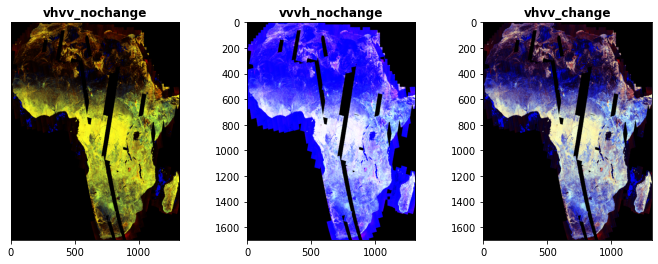

In [57]:
#create four plots next to each other 
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(12, 4))


# Plot first four files
show(images[0], ax=ax1, title='vhvv_nochange')
show(images[1], ax=ax2, title='vvvh_nochange')
show(images[2], ax =ax3, title='vhvv_change')

# Do not show y-ticks values in last three axis
for ax in [ax1]:
    ax.yaxis.set_visible(False)

## Conclusions

In the example above, we can see these four fields are following the same cropping schedule and are therefore likely the same species of crop. We can also observe intra-field differences in the rates of growth, and in the NDVI values at different times of the season, which may be attributable to differences in soil quality, watering intensity, or other farming practices. 

Phenology statistics are a powerful way to summarise the seasonal cycle of a plant's life.  Per-pixel plots of phenology can help us understand the timing of vegetation growth and seasonality across large areas and across diverse plant species as every pixel is treated as an independent series of observations. This could be important, for example, if we wanted to assess how the growing seasons are shifting as the climate warms.  


***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [36]:
print(datacube.__version__)

1.8.4.dev63+g6ee0462c


**Last Tested:**

In [37]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2021-05-06'